In [3]:
# Description
"""

Last modified 11.02.2016
    Added mongoDB support
    pandas avr_table dumps to csv file in 'folder' directory 

08.02.2016
Pandas functionality added, now can be saved to database

New - sifting works correctly, 
        in dataD images which are sifted indicated as isgood=False, 
        fits now use parame
        ter sigma = 'yerr' to calculate fit,
        

""";

In [4]:
# Imports and initialization
%pylab inline

import sys
import os
par_dir = os.path.split(os.getcwd())[0]
if par_dir not in sys.path:
    sys.path.append(par_dir)
import inspect
import pickle
import imp
import re
import json
from scipy.optimize import curve_fit
import pandas as pd
from scipy.integrate import quad
from sympy import Symbol, integrate

# from IPython.html import widgets
# from IPython.display import display
# from IPython.html.widgets import interact, interactive, fixed


import thulium_python_lib.usefull_functions as usfuncs
import thulium_python_lib.image_processing_new as impr

import ipyparallel as ipp
ipp.CompositeError.tb_limit = 1

rc1 = ipp.Client()
lview = rc1.load_balanced_view()
dview = rc1.direct_view()
dview['par_dir'] = par_dir
# with dview.sync_imports():
#     import sys, os    
%px import sys, os
%px if par_dir not in sys.path: sys.path.append(par_dir)
%px import thulium_python_lib.image_processing_new as impr
%px import imp
%px from ipyparallel import bind_kernel; bind_kernel()

import datetime
import pymongo
from pymongo import MongoClient
from bson.objectid import ObjectId

# start mongoDB client (mongod server should be launched)
# client = MongoClient('mongodb://localhost:27017/')
client = MongoClient('mongodb://192.168.1.15:27017/')
meas_database = client.measData.meas_data

Populating the interactive namespace from numpy and matplotlib
Done importing, module image_processing now


In [3]:
# to reload library on remote and local engine
# %px imp.reload(impr)
# imp.reload(impr)
# imp.reload(usfuncs)

### And now:


#### Choose working directory and measurement folder

In [4]:
# smth like 'D:\!Data\2015_08_20' for lab and like '/Users/artemgolovizin/Downloads/2015_08_20' for mac
os.chdir(r'\\BIGONE\!Data\2015_07_01\Vertical position/')
# os.chdir(r'/Users/artemgolovizin/Downloads/2015_08_20/')
# print('Current directory', os.getcwd());
current_directory = os.path.split(os.getcwd())[-1]
# Create folder 'Figures' for saving individual plot
if not os.path.exists('Figures'):
    os.makedirs('Figures')
    print('Folder Figures has been created')
working_directory = ''
folder = ''

In [5]:
# specify working folder
folder = '01 LT a=1dBm/'
working_directory = os.path.join(os.getcwd(),folder)
# print('Working directory', working_directory)

dirs = [x for x in os.listdir() if re.match('\d',x)]
meas_type, conf_params, x_lbl, y_lbl, xaxis_calib = impr.get_x_calibration(folder, dirs)

### Load data, rearange, average and calibrate
 Constract loader and averager. For available parameters see help('instance')

In [6]:
# create loader
loader  = impr.Load_Image(dview)
# downloading images
all_data = loader(working_directory,lview)

# rearranging to dictionary
dataD = impr.rearrange_data(all_data)

 180/180 tasks finished after    1 s
done

Total number of images:  180
Rearranging to dictionary is complited


In [7]:
for key in dataD:
    imgs = dataD[key][1]
    #print(key)
    #print([x.image.shape for x in imgs])

In [8]:
# create averager
averager = impr.Avr_Image(dview,do_sifting=True,conf_int=0.1)
# averaging data and fitting
avr_dataD = averager(dataD,lview)

# construct new data dictionary without image and calibration atoms number, size and x-axis
navrD = impr.mod_avrData(avr_dataD, xaxis_calib, impr.N_atoms(width=0.5, delta = 5), impr.real_size)

avr_table = impr.get_pandas_table2(navrD)
# for plotting sifted image

#imshow(imread('1 от частоты амплитудной модуляции аома верди (5) 3.9W/26ms/2_1.png'))
#colorbar()

  18/18 tasks finished after    1 s
done
0 images are sifted in folder=363.890000,shot_typeN=1
0 images are sifted in folder=364.530000,shot_typeN=1
0 images are sifted in folder=364.490000,shot_typeN=1
0 images are sifted in folder=363.690000,shot_typeN=1
0 images are sifted in folder=364.090000,shot_typeN=1
0 images are sifted in folder=363.790000,shot_typeN=1
0 images are sifted in folder=364.290000,shot_typeN=1
1 images are sifted in folder=364.540000,shot_typeN=1
0 images are sifted in folder=364.510000,shot_typeN=1
0 images are sifted in folder=363.490000,shot_typeN=1
0 images are sifted in folder=364.500000,shot_typeN=1
0 images are sifted in folder=364.520000,shot_typeN=1
0 images are sifted in folder=364.490100,shot_typeN=1
0 images are sifted in folder=363.990000,shot_typeN=1
0 images are sifted in folder=363.390000,shot_typeN=1
0 images are sifted in folder=363.590000,shot_typeN=1
0 images are sifted in folder=364.190000,shot_typeN=1
0 images are sifted in folder=364.390000,

In [9]:
# convention table for filenames
impr.meas_types

{'AS': <function thulium_python_lib.image_processing_new.as_measurement>,
 'CL': <function thulium_python_lib.image_processing_new.clock>,
 'FB': <function thulium_python_lib.image_processing_new.feshbach>,
 'LT': <function thulium_python_lib.image_processing_new.lifetime>,
 'PR': <function thulium_python_lib.image_processing_new.parametric_resonance>,
 'T': <function thulium_python_lib.image_processing_new.temperature>}

In [10]:
#help(Figure)

363.39
363.49
363.59
363.69
363.79
363.89
363.99
364.09
364.19
364.29
364.39
364.49
364.4901
364.5
364.51
364.52
364.53
364.54


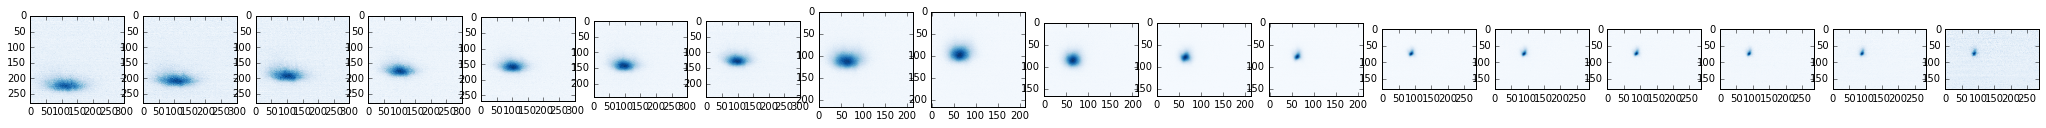

In [11]:
#imshow(avr_dataD[9][1.0].image,cmap=get_cmap('Greens'),vmin=0,vmax=0.01)
fig,ax = subplots(1,len(avr_dataD),figsize=(len(avr_dataD)*2,10))
for i,key in enumerate(sorted(avr_dataD)):
    print(key)
    ax[i].imshow(avr_dataD[key][1.0].image[:,:],cmap=get_cmap('Blues'))
#imshow(avr_dataD[364.49][1.0].image[:150,:200],cmap=get_cmap('Greens'),vmin=0,vmax=0.056)
#colorbar()
#print('Center vertical position', avr_table.T[0].center_pos.x, 'um')
#print('Center horizontal position', avr_table.T[0].center_pos.y, 'um')
#avr_table.T

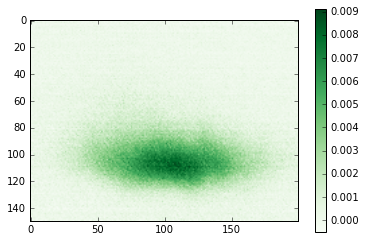

In [12]:
imshow(avr_dataD[363.49][1.0].image[100:250,:200],cmap=get_cmap('Greens'))
colorbar()

363.39
363.49
363.59
363.69
363.79
363.89
363.99
364.09
364.19
364.29
364.39
364.49
364.4901
364.5
364.51
364.52
364.53
364.54


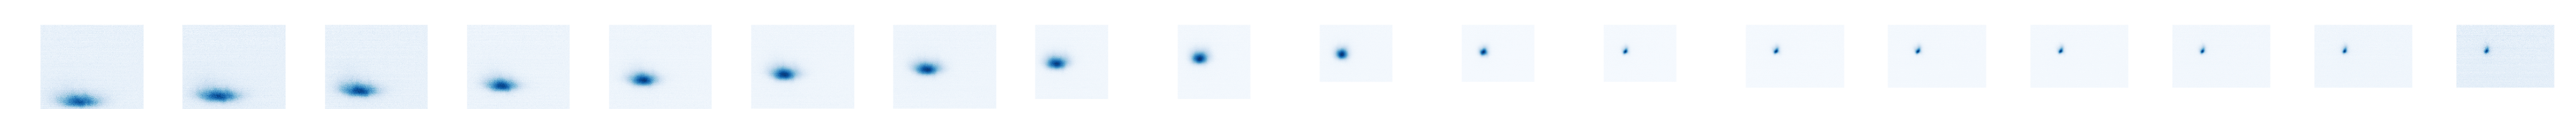

In [13]:
#imshow(avr_dataD[9][1.0].image,cmap=get_cmap('Greens'),vmin=0,vmax=0.01)
fig,ax = subplots(1,len(avr_dataD),figsize=(50,2.5),sharey=True,sharex=True)
tbls = []
for i,key in enumerate(sorted(avr_dataD)):
    print(key)
    ax[i].imshow(avr_dataD[key][1.0].image,cmap=get_cmap('Blues'))
    ax[i].axis('off')
    tbls.append(avr_dataD[key][1.0].image)
#imshow(avr_dataD[364.49][1.0].image[:150,:200],cmap=get_cmap('Greens'),vmin=0,vmax=0.056)
#colorbar()
#print('Center vertical position', avr_table.T[0].center_pos.x, 'um')
#print('Center horizontal position', avr_table.T[0].center_pos.y, 'um')
#avr_table.T

tight_layout()

In [14]:
pd

<module 'pandas' from 'C:\\Program Files\\Anaconda\\lib\\site-packages\\pandas\\__init__.py'>

In [15]:
a = pd.DataFrame(tbls[0])

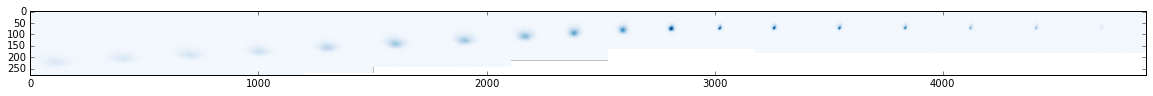

In [34]:
b = pd.concat([pd.DataFrame(avr_dataD[x][1].image) for x in sorted(avr_dataD)],axis=1)
figsize(20,10)
imshow(b,cmap=get_cmap('Blues'))

In [280]:
#help(subplots)

### Construct data based on measurement type and plot

In [362]:
#def linear(x,k,b):
 #   return k*x + b
def linear(x,k,b):
    return k*x + b

In [364]:
t=1
#y, yerr = quad(linear, 0, t, args=(10,0))
x = Symbol('x')
y = integrate (linear(x,1,0), x)
y
#help(integrate)

x**2/2

Number of atoms 653646.0875270439 +- 74909.67371902101


Y:\thulium_python_lib\image_processing_new.py:596: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if data[k]!=None and type(data[k])!=str:


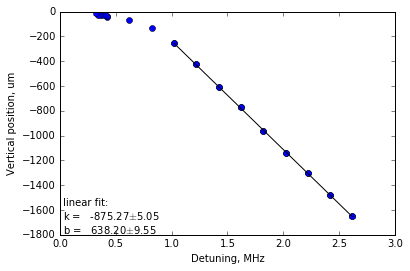

In [13]:
# shot_typeN - for now only 1, if there will be calibration - 1 or more
shot_typeN = 1

# description to add to all_data.txt file
description = dict()
description['meas_type'] = meas_type
description['x_label'] = x_lbl
description['y_label'] = y_lbl

# meas_type = 'T' # here one can specify type to get desired plots
meas_type = 'LT'
fit_func = None
fits_list = []
fig1, ax1 = subplots()
if meas_type == 'T':
    # construct data with cloud expansion on both coordinates
    # first set of data  - Temperature X
    d1 = impr.get_avr_data(navrD, shot_typeN, 'fit1D_x',2)
    d1['fmt']='ro'
    d1['label']='fit1D_x'
    #impr.drop_by_number(d1,5)
    #impr.drop_by_x(d1,130,160)

    # second set of data  - Temperature Y
    d2 = impr.get_avr_data(navrD, shot_typeN,  'fit1D_y',2)
    d2['fmt']='bo'
    d2['label'] = 'fit1D_y'
    #impr.drop_by_number(d2,5)
    
    # fit cloud expansion
    fit_func = usfuncs.cloud_expansion0
    popt_T, pcov_T = curve_fit(fit_func, d1['x'], d1['y'], p0=(d1['y'][0],20))
    perr_T = np.sqrt(np.diag(pcov_T))
    fits_list.append([fit_func.__name__,list(popt_T), list(perr_T)])
    popt_T2, pcov_T2 = curve_fit(fit_func, d2['x'], d2['y'], p0=(d2['y'][0], 20))
    perr_T2 = np.sqrt(np.diag(pcov_T2))
    fits_list.append([fit_func.__name__,list(popt_T2), list(perr_T2)])
#     print('Fit parameters X, Y:\n' + usfuncs.construct_fit_description(fit_func, list(zip(popt_T,popt_T2))))
    
    # plot data and fits 
    ax1.errorbar(**d2)
    ax1.errorbar(**d1)
    ax1.plot(linspace(min(d1['x']),max(d1['x']),100), fit_func(linspace(min(d1['x']),max(d1['x']),100),*popt_T),
             'r', label='Tx=%.2f$\pm$%.1f'%(popt_T[0],perr_T[0]))
    ax1.plot(linspace(min(d2['x']),max(d2['x']),100), fit_func(linspace(min(d2['x']),max(d2['x']),100),*popt_T2),
             'b', label='Ty=%.2f$\pm$%.1f'%(popt_T2[0],perr_T2[0]))
    ax1.set_xlim(min(d1['x'])-1, max(d1['x'])+1)
    # add information about fits to description
    description['fit1D_x'] =  popt_T
    description['fit1D_y'] =  popt_T2
    description['fit-function'] = fit_func.__name__
else:
    # construct data, param - what value to use
    param = ['fit1D_y',1]
    d1 = impr.get_avr_data(navrD, shot_typeN, *param)
    d1['fmt']='bo'
    d1['label']=param
    d1['x'] = 2*364.7-2*d1['x']
    d1['y'] = 800-d1['y']
    #d1['x'] = (2*364.7-2*d1['x'])/0.35
    #impr.drop_by_number(d1,*range(20,len(d1['x'])))
    #impr.drop_by_x(d1,130,160)
    
    param = ['fit1D_y',1]
    d2 = impr.get_avr_data(navrD, shot_typeN, *param)
    d2['fmt']='bo'
    d2['label']=param
    d2['x'] = 2*364.7-2*d2['x']
    d2['y'] = 800-d2['y']
    #d2['x'] = (2*364.7-2*d2['x'])/0.35
    impr.drop_by_number(d2,18,17,16,15,14,13,12,11,10,9)
    
    #ax1.errorbar(**d1)
    #ax1.errorbar(**d2)
    
    # fit_func - which function to use to fit data  here one can put conditions on meas_type to choose fit
    popt_T = None
    # fit_func = usfuncs.exp_decay_no_bg
    # popt_T, pcov_T = curve_fit(fit_func, d1['x'], d1['y'], p0=(d1['y'][0], 100))
    fit_func = linear
    popt_T, pcov_T = curve_fit(fit_func, d2['x'], d2['y'])
    
#     #popt_T, pcov_T = curve_fit(fit_func, d1['x'], d1['y'], p0=(-d1['y'][0], d1['x'][argmin(d1['y'])],0.1,d1['y'][0]))
#     print('Fit parameters:\n' + usfuncs.construct_fit_description(fit_func, popt_T))
    perr_T = np.sqrt(np.diag(pcov_T))
    
    # plot data and fits
    ax1.errorbar(**d1)
    ax1.errorbar(**d2)
    if fit_func != None:
        ax1.plot(linspace(min(d2['x']),max(d2['x']),100), fit_func(linspace(min(d2['x']),max(d2['x']),100),*popt_T),'k', label='fit X')
        fit_label = fit_func.__name__ + ' fit:\n' + usfuncs.construct_fit_description(fit_func, list(zip(popt_T,perr_T)),sep='$\pm$')
        ax1.text(0.01,0.01,fit_label,transform=ax1.transAxes)
        description['fit'] =  popt_T
        description['fit-function'] = fit_func.__name__
        fits_list.append([fit_func.__name__,list(popt_T), list(perr_T)])
    
x_lbl='Detuning, MHz'
y_lbl='Vertical position, um'
ax1.set_xlabel(x_lbl)
ax1.set_ylabel(y_lbl)
#ax1.set_title(folder.rstrip(r'\/ '))
#ax1.set_ylim(bottom=0)
#ax1.legend(loc=4)

print('Number of atoms', avr_table.T[0].fit1D_x.N, '+-', avr_table.T[0].fit1D_x_std.N)

In [86]:
#help(errorbar)
navrD.keys()

dict_keys([363.89, 364.53, 364.49, 363.69, 364.09, 363.79, 364.29, 364.54, 364.51, 363.49, 364.5, 364.52, 364.4901, 363.99, 363.39, 363.59, 364.19, 364.39])

(0, 60.0)

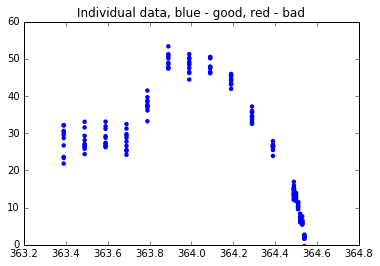

In [115]:
# for each picture
shot_typeN = 1
xs, ys, cs = impr.constract_data_scatter(dataD, shot_typeN, 'fit1D_y',0)
# plt.figure(figsize=(13,4))
scatter(xs,ys,c=cs,linewidths=0)
title("Individual data, blue - good, red - bad")
ylim(bottom=0)

In [116]:
# show 2D image
# imshow(avr_dataD[0.2][1].image)

In [117]:
if folder != '':
    fig1.savefig(os.path.join('Figures',folder.rstrip(r'\/ ')+'.png'))
    # save pandas table to csv file
    avr_table.to_csv(os.path.join(folder,'avr_table.csv'))
    try:
        with open('all_data.txt', 'rb') as handle:
            res_dict = pickle.loads(handle.read())
    except FileNotFoundError:
        res_dict = {}
    except EOFError:
        res_dict = {}
    res_dict[folder.rstrip(r'\/ ')]={'description':description,'data':navrD}
    with open('all_data.txt', 'wb') as handle:
        pickle.dump(res_dict, handle)
    with open('all_data.json', 'w') as outfile:
        json.dump(res_dict, outfile, cls=impr.JsonCustomEncoder, indent=4)    
    print('Figure and data saved!!!')
    
# to later read json file run following two lines
#with open('all_data.json', 'r') as infile:
#        ddata = json.load(infile)

#save to mongo db
# get pickle string of avr_table 
ss = 'temp'
avr_table.to_pickle(ss)
with open(ss,'rb') as fl:
    line = fl.read()
os.remove(ss)
# prepear dictionary to load to mongoDB
data_to_db = {
             'date_meas':datetime.datetime.strptime(current_directory[:10],'%Y_%m_%d'),
             'date_mod':datetime.datetime.now(),
             'folder':folder,
             'meas_type':meas_type,
             'labels':[x_lbl, y_lbl],
              'conf_params':conf_params,
              'fits': fits_list,
              'avr_table_pickle':line
             }
# try to find entery with the same 'date_meas' and 'folder' and either update or create entery
res = meas_database.find_one({'date_meas':datetime.datetime.strptime(current_directory[:10],'%Y_%m_%d'),
                 'folder':folder})
if res:
    print('Entery for folder "%s" updated' % folder)
    meas_database.update_one({'_id':res['_id']},{'$set':data_to_db})
else:
    print('Entery for folder "%s" created' % folder)
    meas_database.insert_one(data_to_db)

Figure and data saved!!!


ValueError: time data 'Vertical p' does not match format '%Y_%m_%d'

#### Force and Potential for MOT

In [371]:
γ=0.350 # MHz
#γ=0.0075 # MHz
Γ=2*pi*γ # MHz

λ=531*10**(-9) # nm
#λ=689*10**(-9) # nm
k=2*pi/λ

μB=927.4*10**(-26) # Дж/Тл
hbar=10**(-34) # Дж*с
μ=1*μB/hbar
dB=19*10**(-2)/4*1.5 # Тл/м

m=169*1.66*10**(-27) # kg
#m=88*1.66*10**(-27) # kg
g=10 # m/s

kB=1.38*10**(-23) # Дж/К

def Force(δ,s,v,z):
    return (0.5*hbar*k*Γ*10**6)*(s/(1+s+4*(2*pi*δ-k*v*10**(-6)-μ*dB*10**(-9)*z)**2/Γ**2)-s/(1+s+4*(2*pi*δ+k*v*10**(-6)+μ*dB*10**(-9)*z)**2/Γ**2)) - m*g

def Potential(δ,s,v,z): # проинтегрировано в Математике
    return -10**(-3)*(0.5*hbar*k*Γ*10**6)*(s*pi*γ*10**9/(dB*μ*sqrt(1+s)))*(arctan((-2*pi*λ*δ+2*pi*v*10**(-6)+λ*μ*dB*10**(-9)*z)/(γ*λ*pi*sqrt(1+s))) - arctan((2*pi*λ*δ+2*pi*v*10**(-6)+λ*μ*dB*10**(-9)*z)/(γ*λ*pi*sqrt(1+s)))) + 10**(-3)*m*g*z
# коэффициент 10**(-3) из-за того, что z в миллиметрах
#z=Symbol('z')
#δ=Symbol('δ')
#s=Symbol('s')
#Force(δ,s,0,z)

#### Стронций, для сравнения со статьей, сила от координаты или скорости при разных отстройках

950.8848063712676 мкм/МГц


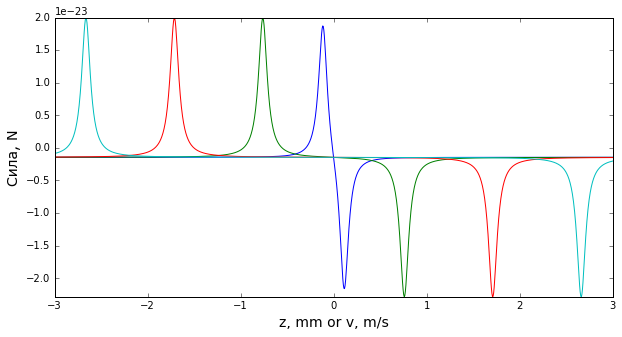

In [433]:
# стронций, для сравнения со статьей, сила

γ=0.0075 # MHz
Γ=2*pi*γ # MHz
λ=689*10**(-9) # nm
k=2*pi/λ
m=88*1.66*10**(-27) # kg
dB=19*10**(-2)/4*1.5 # Тл/м

z = linspace(-3,3,1000) # mm for z or m/s for v
v = 0
s = 250

figsize(10,5)
for δ in [-0.12,-0.8,-1.8,-2.8]: # MHz
    y = Force(δ,s,v,z) # dependence on z
    #y = Force(δ,s,z,v) # dependence on v
    plot(z,y)

print(2*pi*10**(12)/(μ*dB),'мкм/МГц')
axis('tight')
xlabel('z, mm or v, m/s', fontsize=14)
ylabel('Сила, N', fontsize=14, family="verdana")

#### Стронций, для сравнения со статьей, потенциал от координаты при разных отстройках

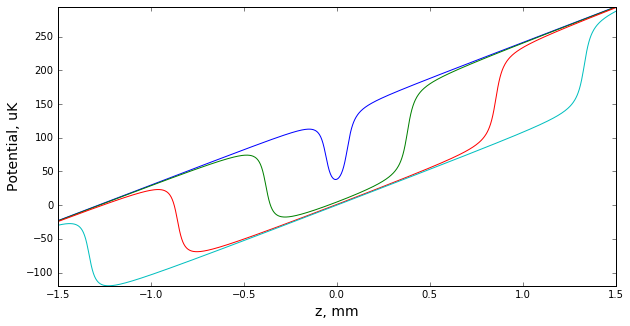

In [384]:
# стронций, для сравнения со статьей, потенциал

γ=0.0075 # MHz
Γ=2*pi*γ # MHz
λ=689*10**(-9) # nm
k=2*pi/λ
m=88*1.66*10**(-27) # kg
dB=2*19*10**(-2)/4*1.5 # Тл/м

z = linspace(-1.5,1.5,1000) # mm
v = 0
s = 250

figsize(10,5)
for δ in [-0.12,-0.8,-1.8,-2.8]: # MHz
    y = 10**6*(Potential(δ,s,v,z) - Potential(-2.8,s,v,0))/kB
    plot(z,y)
    
axis('tight')
xlabel('z, mm', fontsize=14)
ylabel('Potential, uK', fontsize=14)

#### Стронций, для сравнения со статьей, сила от координаты или скорости при разных мощностях

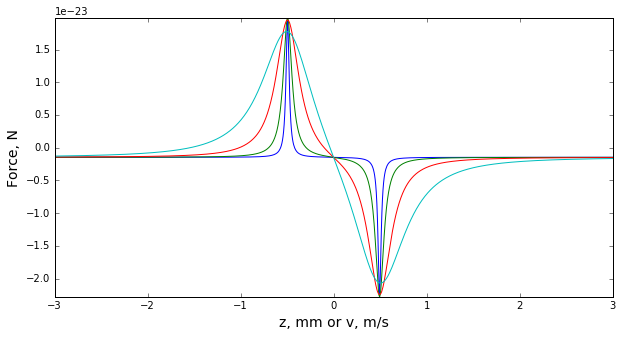

In [385]:
# стронций, для сравнения со статьей, сила

γ=0.0075 # MHz
Γ=2*pi*γ # MHz
λ=689*10**(-9) # nm
k=2*pi/λ
m=88*1.66*10**(-27) # kg
dB=19*10**(-2)/4*1.5 # Тл/м

z = linspace(-3,3,1000) # mm for z or m/s for v
v = 0
δ = -0.52

figsize(10,5)
for s in [33,248,1800,9120]:
    y = Force(δ,s,v,z) # dependence on z
    #y = Force(δ,s,z,v) # dependence on v
    plot(z,y)

#print(2*pi*10**(12)/(μ*dB),'мкм/МГц')
axis('tight')
xlabel('z, mm or v, m/s', fontsize=14)
ylabel('Force, N', fontsize=14)

#### Стронций, для сравнения со статьей, потенциал от координаты при разных мощностях

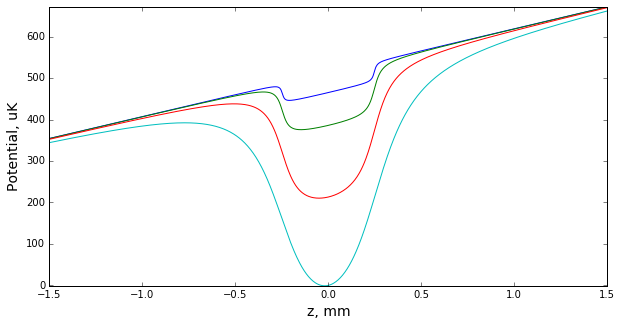

In [387]:
# стронций, для сравнения со статьей, потенциал

γ=0.0075 # MHz
Γ=2*pi*γ # MHz
λ=689*10**(-9) # nm
k=2*pi/λ
m=88*1.66*10**(-27) # kg
dB=2*19*10**(-2)/4*1.5 # Тл/м

z = linspace(-1.5,1.5,1000) # mm
v = 0
δ = -0.52

figsize(10,5)
for s in [33,248,1800,9120]:
    y = 10**6*(Potential(δ,s,v,z) - Potential(δ,9120,v,0))/kB
    plot(z,y)
    
axis('tight')
xlabel('z, mm', fontsize=14)
ylabel('Potential, uK', fontsize=14)

#### Тулий, сила от координаты или скорости при разных отстройках

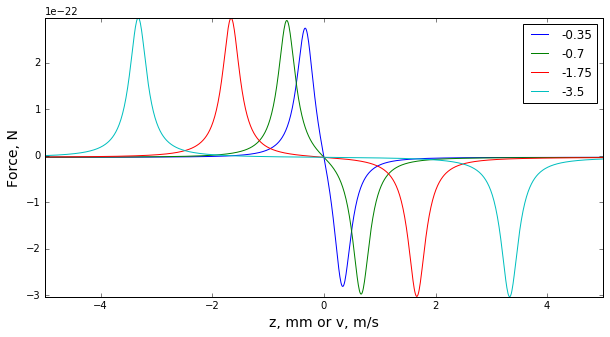

In [420]:
# тулий, сила

γ=0.35 # MHz
Γ=2*pi*γ # MHz
λ=531*10**(-9) # nm
k=2*pi/λ
m=169*1.66*10**(-27) # kg
dB=19*10**(-2)/4*1.5 # Тл/м

z = linspace(-5,5,1000) # mm for z or m/s for v
v = 0
s = 0.3

figsize(10,5)
δset=[-γ,-2*γ,-5*γ,-10*γ]
#print(-6*γ)
for δ in δset: # MHz
    y = Force(δ,s,v,z) # dependence on z
    #y = Force(δ,s,z,v) # dependence on v
    plot(z,y)

#print(2*pi*10**(12)/(μ*dB),'мкм/МГц')
axis('tight')
xlabel('z, mm or v, m/s', fontsize=14)
ylabel('Force, N', fontsize=14)
legend(δset)

#### Тулий, потенциал от координаты при разных отстройках

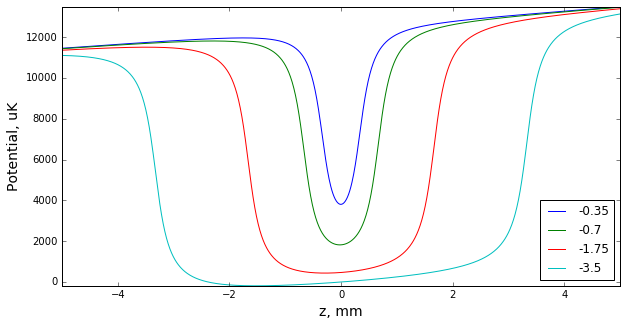

In [423]:
# Тулий, потенциал

γ=0.35 # MHz
Γ=2*pi*γ # MHz
λ=531*10**(-9) # nm
k=2*pi/λ
m=169*1.66*10**(-27) # kg
dB=19*10**(-2)/4*1.5 # Тл/м

z = linspace(-5,5,1000) # mm for z or m/s for v
v = 0
s = 0.3

figsize(10,5)
for δ in δset: # MHz
    y = 10**6*(Potential(δ,s,v,z) - Potential(-10*γ,s,v,0))/kB
    plot(z,y)
    
axis('tight')
xlabel('z, mm', fontsize=14)
ylabel('Potential, uK', fontsize=14)
legend(δset,loc=4)

#### Тулий, сила от координаты при разных мощностях

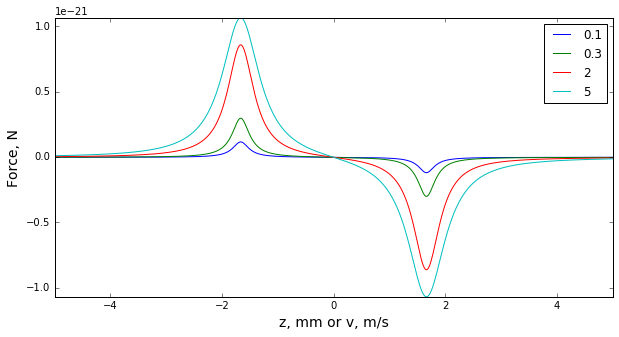

In [426]:
# тулий, сила

γ=0.35 # MHz
Γ=2*pi*γ # MHz
λ=531*10**(-9) # nm
k=2*pi/λ
m=169*1.66*10**(-27) # kg
dB=19*10**(-2)/4*1.5 # Тл/м

z = linspace(-5,5,1000) # mm for z or m/s for v
v = 0
δ = -5*γ

figsize(10,5)
sset=[0.1,0.3,2,5]
for s in sset: # MHz
    y = Force(δ,s,v,z) # dependence on z
    #y = Force(δ,s,z,v) # dependence on v
    plot(z,y)

#print(2*pi*10**(12)/(μ*dB),'мкм/МГц')
axis('tight')
xlabel('z, mm or v, m/s', fontsize=14)
ylabel('Force, N', fontsize=14)
legend(sset)

#### Тулий, потенциал от координаты при разных мощностях

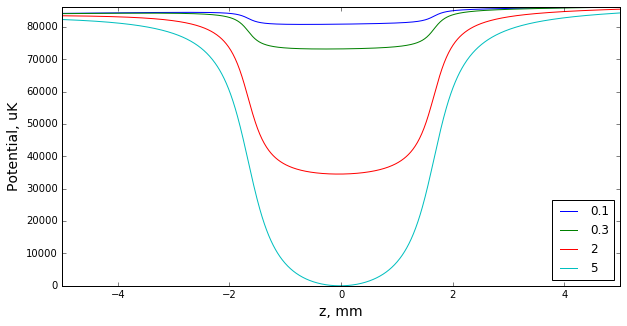

In [427]:
# Тулий, потенциал

γ=0.35 # MHz
Γ=2*pi*γ # MHz
λ=531*10**(-9) # nm
k=2*pi/λ
m=169*1.66*10**(-27) # kg
dB=19*10**(-2)/4*1.5 # Тл/м

z = linspace(-5,5,1000) # mm for z or m/s for v
v = 0
δ = -5*γ

figsize(10,5)
for s in sset: # MHz
    y = 10**6*(Potential(δ,s,v,z) - Potential(δ,max(sset),v,0))/kB
    plot(z,y)
    
axis('tight')
xlabel('z, mm', fontsize=14)
ylabel('Potential, uK', fontsize=14)
legend(sset,loc=4)